# Для запуска в colab

In [49]:
# fast версия для pymotphy2 не работает на python3.7!!!
# Использовать только python3.6 либо python3.8
# !pip install --user bigartm10 pymorphy2[fast] pyLDAvis

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Библиотеки

In [168]:
import itertools

from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
# не очень много стоп слов, но для задания хватит
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import pymorphy2
import nltk
import gc

import datetime

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/local/AP-
[nltk_data]     TEAM/grabovoy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Работа с данными

## Загрузка датасета

In [5]:
data = pd.read_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-filtered.csv')

## Анализ

In [6]:
data

,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


In [7]:
data.describe()

,len
count,863285.000000
mean,1341.245505
std,572.066583
min,3.000000
25%,980.000000
50%,1253.000000
75%,1596.000000
max,55387.000000


Видно, что новостные заметки занимают порядка 1.2 кб текста, что является порядка 3/4 страницы А4 печатного текста. Данная длина текста приемлема для анализа, так как не является слишком короткими (как например твиты, порядка 0.2 кб).

Заметим, что в данных присутсвует поле tags (посути это можно рассматривать как топик). Данное поле будет интерестно в последующем анализе.

In [8]:
topics = [x.lower() for x in np.unique(np.array(data['tags'].values, dtype=str)).tolist() if x != 'nan']

In [9]:
len(topics), topics[:10]

(94,
 ['69-я параллель',
  'coцсети',
  'авто',
  'автобизнес',
  'аналитика рынка',
  'английский футбол',
  'белоруссия',
  'бизнес',
  'бокс и мма',
  'вещи'])

## Предобработка

Выполним простую предобработку текстов:
- lowercase;
- лемматизация при помощи pymorphy2;
- удаление стоп слов из словаря nltk.

In [10]:
# Честно взято с реализации ru_sentencetokenizer от iPavlov.
# Переписано в класс (к сожалению очень давно переписал и быстро сами пакет от 
#          iPavlov найти не смог,мне быстрее было взять свой пофикшеный код...)
import re
import logging
from typing import Set, Tuple, List
class RuSentenceTokenizer(object):
    def __init__(self):
        self.SENT_RE = re.compile(r'[^\.?!…]+[\.?!…]*["»“]*')

        self._LAST_WORD = re.compile(r'(?:\b|\d)([a-zа-я]+)\.$', re.IGNORECASE)
        self._FIRST_WORD = re.compile(r'^\W*(\w+)')
        self._ENDS_WITH_ONE_LETTER_LAT_AND_DOT = re.compile(r'(\d|\W|\b)([a-zA-Z])\.$')
        self._HAS_DOT_INSIDE = re.compile(r'[\w]+\.[\w]+\.$', re.IGNORECASE)
        self._INITIALS = re.compile(r'(\W|\b)([A-ZА-Я]{1})\.$')
        self._ONLY_RUS_CONSONANTS = re.compile(r'^[бвгджзйклмнпрстфхцчшщ]{1,4}$', re.IGNORECASE)
        self._STARTS_WITH_EMPTYNESS = re.compile(r'^\s+')
        self._ENDS_WITH_EMOTION = re.compile(r'[!?…]|\.{2,}\s?[)"«»,“]?$')
        self._STARTS_WITH_LOWER = re.compile(r'^\s*[–-—-("«]?\s*[a-zа-я]')
        self._STARTS_WITH_DIGIT = re.compile(r'^\s*\d')
        self._NUMERATION = re.compile(r'^\W*[IVXMCL\d]+\.$')
        self._PAIRED_SHORTENING_IN_THE_END = re.compile(r'\b(\w+)\. (\w+)\.\W*$')

        self._JOIN = 0
        self._MAYBE = 1
        self._SPLIT = 2

        self.JOINING_SHORTENINGS = {'mr', 'mrs', 'ms', 'dr', 'vs', 'англ', 'итал', 'греч', 'евр', 'араб', 'яп', 'слав', 'кит',
                               'тел', 'св', 'ул', 'устар', 'им', 'г', 'см', 'д', 'стр', 'корп', 'пл', 'пер', 'сокр', 'рис'}
        self.SHORTENINGS = {'co', 'corp', 'inc', 'авт', 'адм', 'барр', 'внутр', 'га', 'дифф', 'дол', 'долл', 'зав', 'зам', 'искл',
                       'коп', 'корп', 'куб', 'лат', 'мин', 'о', 'обл', 'обр', 'прим', 'проц', 'р', 'ред', 'руб', 'рус', 'русск',
                       'сан', 'сек', 'тыс', 'эт', 'яз', 'гос', 'мн', 'жен', 'муж', 'накл', 'повел', 'букв', 'шутл', 'ед'}

        self.PAIRED_SHORTENINGS = {('и', 'о'), ('т', 'е'), ('т', 'п'), ('у', 'е'), ('н', 'э')}
        
        # whitespaces
        self.start_whitespace = re.compile('^\s+')
        self.end_whitespace = re.compile('\s+$')
    
    
    def _regex_split_separators(self, text: str) -> [str]:
        return [x.strip() for x in self.SENT_RE.findall(text)]
    
    def _is_sentence_end(self, left: str, 
                               right: str,
                               shortenings: Set[str],
                               joining_shortenings: Set[str],
                               paired_shortenings: Set[Tuple[str, str]]) -> int:
        if not self._STARTS_WITH_EMPTYNESS.match(right):
            return self._JOIN

        if self._HAS_DOT_INSIDE.search(left):
            return self._JOIN

        left_last_word = self._LAST_WORD.search(left)
        lw = ' '
        if left_last_word:
            lw = left_last_word.group(1)

            if lw.lower() in joining_shortenings:
                return self._JOIN

            if self._ONLY_RUS_CONSONANTS.search(lw) and lw[-1].islower():
                return self._MAYBE

        pse = self._PAIRED_SHORTENING_IN_THE_END.search(left)
        if pse:
            s1, s2 = pse.groups()
            if (s1, s2) in paired_shortenings:
                return self._MAYBE

        right_first_word = self._FIRST_WORD.match(right)
        if right_first_word:
            rw = right_first_word.group(1)
            if (lw, rw) in paired_shortenings:
                return self._MAYBE

        if self._ENDS_WITH_EMOTION.search(left) and self._STARTS_WITH_LOWER.match(right):
            return self._JOIN

        initials = self._INITIALS.search(left)
        if initials:
            border, _ = initials.groups()
            if (border or ' ') not in "°'":
                return self._JOIN

        if lw.lower() in shortenings:
            return self._MAYBE

        last_letter = self._ENDS_WITH_ONE_LETTER_LAT_AND_DOT.search(left)
        if last_letter:
            border, _ = last_letter.groups()
            if (border or ' ') not in "°'":
                return self._MAYBE
        if self._NUMERATION.match(left):
            return self._JOIN
        return self._SPLIT
    
    def tokenize(self, text: str,
                       shortenings: Set[str] = None,
                       joining_shortenings: Set[str] = None,
                       paired_shortenings: Set[Tuple[str, str]] = None) -> List[str]:
        
        spans = self.span_tokenize(text, shortenings, joining_shortenings, paired_shortenings)
        
        sentences = []
        for span in spans:
            sentences.append(text[span[0]:span[1]])
        
        return sentences
    
    def _span_strip(self, text, sent_start, span_end):
        # delete whitespace start spans
        start_whitespace = self.start_whitespace.search(text[sent_start: span_end])
        if start_whitespace:
            sent_start += (start_whitespace.span(0)[1] - start_whitespace.span(0)[0])
        # delete whitespace end spans
        end_whitespace = self.end_whitespace.search(text[sent_start: span_end])
        if end_whitespace:
            span_end -= (end_whitespace.span(0)[1] - end_whitespace.span(0)[0])
            
        return sent_start, span_end
    
    def span_tokenize(self, text,
                            shortenings: Set[str] = None,
                            joining_shortenings: Set[str] = None,
                            paired_shortenings: Set[Tuple[str, str]] = None) -> List[Tuple]:
        
        if shortenings is None:
            shortenings = self.SHORTENINGS
        if joining_shortenings is None:
            joining_shortenings = self.JOINING_SHORTENINGS
        if paired_shortenings is None:
            paired_shortenings = self.PAIRED_SHORTENINGS
    
        spans = []
        sents = self._regex_split_separators(text)
        si = 0
        processed_index = 0
        sent_start = 0
        while si < len(sents):
            s = sents[si]
            span_start = text[processed_index:].index(s) + processed_index
            span_end = span_start + len(s)
            processed_index += len(s)

            si += 1

            send = self._is_sentence_end(text[sent_start: span_end], 
                                         text[span_end:],
                                         shortenings, 
                                         joining_shortenings, 
                                         paired_shortenings)
            if send == self._JOIN:
                continue

            if send == self._MAYBE:
                if self._STARTS_WITH_LOWER.match(text[span_end:]):
                    continue
                if self._STARTS_WITH_DIGIT.match(text[span_end:]):
                    continue
                    
            sent_start, span_end = self._span_strip(text, sent_start, span_end)

            if not text[sent_start: span_end].strip():
                logging.debug("Something went wrong while tokenizing")
            else:
                spans.append((sent_start, span_end))
            
            sent_start = span_end
            processed_index = span_end

        if sent_start != len(text):
            if text[sent_start:].strip():
                sent_start, span_end = self._span_strip(text, sent_start, len(text))
                spans.append((sent_start, span_end))
        return spans

In [11]:
# уже давно пользуюсь для себя унифицированными токенизаторами
word_tokenizer = RegexpTokenizer('[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = RuSentenceTokenizer()
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = stopwords.words('russian')

In [12]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer.tokenize(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [172]:
# data_text = data['text']
# for i in tqdm(range(len(data))):
#     data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
# data.to_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-proccess.csv', index=False)

# препроцесинг занимает порядка двух часов, поэтому рекомендуется загрузисть
# сразу обработанную версию
data = pd.read_csv('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/lenta-ru-proccess.csv')

In [173]:
data

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


## Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [174]:
filename_valid = 'drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt'
filename_train = 'drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt'


counter_train = 0
counter_valid = 0

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = '_'.join(data.loc[i]['date'].split('-')[1:])


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@month class_{}\n'.format(counter_train, ' '.join(text), label))
                    counter_train += 1
                else:
                    fout_train.write('doc_{} {} |@month class_{}\n'.format(counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    

<>:8: DeprecationWarning: invalid escape sequence \W
<>:8: DeprecationWarning: invalid escape sequence \W
<>:8: DeprecationWarning: invalid escape sequence \W
<ipython-input-174-92174770a520>:8: DeprecationWarning: invalid escape sequence \W
  reg = re.compile('\W+')


In [175]:
# освободим немного память
del data

gc.collect()

In [177]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@month class_

In [178]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt

6604 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_valid.vw.txt


In [179]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

In [180]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt

653795 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts_train.vw.txt


# BigARTM модель

In [181]:
import artm
import pyLDAvis

In [182]:
artm.ARTM(num_topics=1)
print(artm.version())

0.9.2


## Создаем батчи

In [185]:
bv_train = artm.BatchVectorizer(data_path=filename_train, 
                                data_format='vowpal_wabbit', 
                                batch_size=10000, 
                                target_folder='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_train')


In [187]:
# Важно, пути target_folder должны быть отличны от предыдущей
bv_test = artm.BatchVectorizer(data_path=filename_valid, 
                               data_format='vowpal_wabbit', 
                               batch_size=10000, 
                               target_folder='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_valid')



## Создаем словарь слов по заданым батчам

In [188]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_train')

## Инициализируем модель

In [189]:
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             '@month': 10.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=bv.dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@month'))

## Обучаем модель с самого начала, без регуляризаторов

In [ ]:
iterator = tqdm(range(50))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [148]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'исследователь', 'анализ', 'который', 'журнал', 'клетка', 'результат', 'университет', 'изучить']
['год', '2007', '2005', '2004', '2003', '2000', '2002', 'испания', 'сообщать', '1999']
['германия', 'немецкий', 'берлин', 'фрг', 'зелёный', 'меркель', 'канцлер', 'который', 'ангел', 'немец']
['министерство', 'предложение', 'выступить', 'зона', 'конференция', 'инициатива', 'необходимость', 'конкретный', 'обсуждаться', 'который']
['решение', 'документ', 'принять', 'срок', 'соответствующий', 'запрет', 'положение', 'подготовить', 'введение', 'вступить']
['украина', 'украинский', 'киев', 'порошенко', 'янукович', 'киевский', 'это', 'украинец', 'гривна', 'сбу']
['глава', 'январь', 'февраль', 'который', 'отправить', 'заявлять', 'стать', 'анатолий', 'это', 'просить']
['июль', 'август', 'государственный', 'деятельность', 'пятница', 'контроль', 'агентство', 'это', 'также', 'ранее']
['директор', 'руководитель', 'заместитель', 'генеральный', 'департамент', 'гендиректор', 'испо

In [149]:
month_modal = []
with open('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/texts.vw.txt') as f:
    for line in tqdm(f):
        string = re.search(r'@month class_(\d\d_\d\d\d\d)\n', line).group(1)
        month_modal.append(datetime.datetime.strptime(string, '%m_%Y'))

month_modal = np.array(month_modal)

In [150]:
predict = model.transform(bv)

In [151]:
unique_modal = np.unique(month_modal)

In [152]:
mean_vectors = []
for modal in tqdm(unique_modal):
    mean_vectors.append(predict[np.where(month_modal == modal)[0]].values.mean(axis=-1))
    
mean_vectors = np.array(mean_vectors)

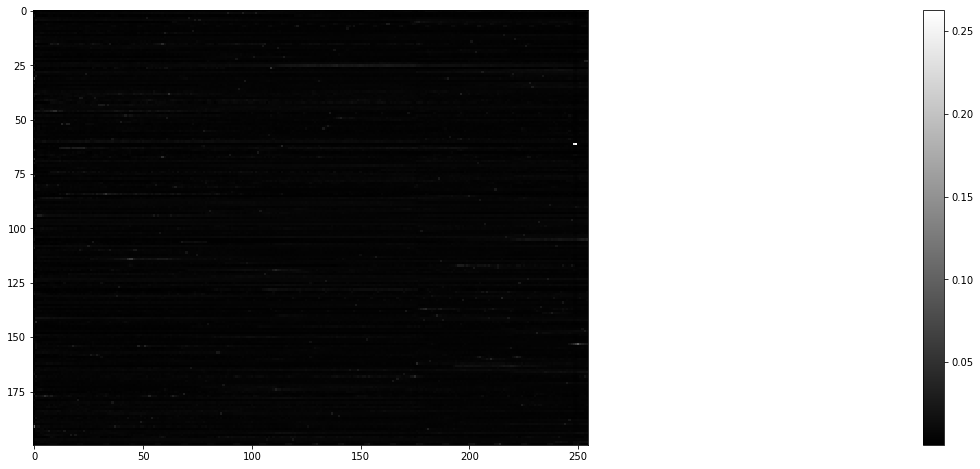

In [153]:
fig = plt.figure(figsize=(120, 8))

im = plt.imshow(mean_vectors.T, cmap='gray')
_ = fig.colorbar(im)

plt.show()